# Exploration of DrugMechDB

Here, I explore [DrugMechDB](https://sulab.github.io/DrugMechDB/) which could ideally provide us with true positive paths / MOAs.

In [63]:
import pandas as pd
import os.path as osp
from collections import Counter
from urllib import request
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
import numpy as np
import math

## Load in the DrugMechDB file:

In [2]:
VALIDATION_DIR = '../data/validation'

The database download comes as an excel file with many separate sheets, so it needs to be read in as separate dataframes:

In [3]:
dm_db = pd.ExcelFile(osp.join(VALIDATION_DIR, 'indication_MOA_paths.xlsx'))

In [4]:
indications = pd.read_excel(dm_db, 'sample_indications')

In [5]:
indications.head()

,name,num_ind_dc,db_id,comp_mesh_ids,disease_name,dis_mesh_id,Comments
0,imatinib,11.0,DB00619,MESH:D000068877,CML (ph+),MESH:D015464,"Multiple ways to represent this path, experime..."
1,imatinib,11.0,DB00619,MESH:D000068877,Systemic mast cell disease,MESH:D034721,NaN
2,imatinib,11.0,DB00619,MESH:D000068877,Systemic mast cell disease,MESH:D034721,NaN
3,acetaminophen,NaN,DB00316,MESH:D000082,Pain,MESH:D010146,"Multiple ways to represent this path, experime..."
4,acetaminophen,NaN,DB00316,MESH:D000082,Pain,MESH:D010146,NaN


We can see the the drugs are provided as [DrugBank](https://go.drugbank.com) identifiers, and the diseases are providued as [MeSh identifiers](https://www.nlm.nih.gov/mesh/meshhome.html). 

Let's look at the paths:

## Path Instances in DrugMechDB

In [6]:
paths = pd.read_excel(dm_db, 'paths')

In [7]:
paths.head()

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,imatinib,INHIBITS,BCR/ABL,CAUSES,CML (ph+),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,imatinib,INHIBITS,c-Kit,UP_REGULATES,Cellular proliferation,CAUSES,Systemic mast cell disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,imatinib,INHIBITS,Pdgf,UP_REGULATES,Cellular proliferation,CAUSES,Systemic mast cell disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,acetaminophen,INHIBITS,cycloxygenaze pathways,ASSOCIATED_WITH,Pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,acetaminophen,INHIBITS,Cox-1,PRODUCES,Prostaglandins,CAUSES,Pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


How long are most of the paths? I'll define the length of the paths as the number of edges/hops.

In [8]:
Counter([(row.count() - 1) / 2 for i, row in paths.iterrows()])

Counter({4.0: 59, 3.0: 38, 2.0: 13, 5.0: 8, 1.0: 3, 7.0: 1, 6.0: 1})

It looks like most are length 4.

Only 3 are above length 5.

What if we only take those which end in a biological process?

It might be better to work from the JSON file instead, which can be found [here](https://github.com/SuLab/DrugMechDB/blob/1.0/indication_paths.json). In contrast to the paths in the dataframe, the JSON version has the types for each node.

In [9]:
url = "https://raw.githubusercontent.com/SuLab/DrugMechDB/1.0/indication_paths.json"
filepath = osp.join(VALIDATION_DIR, "drugmechdb_paths.json")

In [10]:
with request.urlopen(url) as fl:
    data_json = json.loads(fl.read())
    #json.dump(dict(data_json), filepath)
    #print(data_json)

Are there the same number of paths as before?

In [11]:
len(data_json)

123

In [12]:
len(data_json) == len(paths)

True

Let's take a look at an example path:

In [13]:
data_json[1]

{'directed': True,
 'multigraph': True,
 'graph': {'drug': 'imatinib',
  'disease': 'Systemic mast cell disease',
  'drugbank': 'DB00619',
  'drug_mesh': 'MESH:D000068877',
  'disease_mesh': 'MESH:D034721'},
 'nodes': [{'id': 'MESH:D000068877', 'name': 'imatinib', 'label': 'Drug'},
  {'id': 'UniProt:P10721', 'name': 'c-Kit', 'label': 'Protein'},
  {'id': 'GO:0008283',
   'name': 'Cellular proliferation',
   'label': 'Biological Process'},
  {'id': 'MESH:D034721',
   'name': 'Systemic mast cell disease',
   'label': 'Disease'}],
 'links': [{'source': 'MESH:D000068877',
   'target': 'UniProt:P10721',
   'key': 'INHIBITS'},
  {'source': 'UniProt:P10721', 'target': 'GO:0008283', 'key': 'UP_REGULATES'},
  {'source': 'GO:0008283', 'target': 'MESH:D034721', 'key': 'CAUSES'}]}

We can get the number of nodes involved:

In [14]:
len(data_json[1]['nodes'])

4

... and using that, get the second-to-last node (the last is always a disease).

In [15]:
data_json[1]['nodes'][len(data_json[1]['nodes']) - 2]

{'id': 'GO:0008283',
 'name': 'Cellular proliferation',
 'label': 'Biological Process'}

Cool, let's create a new object containing only those which end in a BP node.

Let's also get all the unique BPs involved:

In [16]:
bp_paths = []
bp_path_lengths = []
bps = set()
for path in data_json:
    # if second to last node is BP,
    if path['nodes'][len(path['nodes']) - 2]['label'] == 'Biological Process':
        bp_paths.append(path)
        bp_path_lengths.append(len(path['links']))
        bps.add(path['nodes'][len(path['nodes']) - 2]['id'])

How many of the 162 paths end in a BP?

In [17]:
len(bp_paths)

62

In [18]:
Counter(bp_path_lengths)

Counter({3: 25, 4: 24, 5: 7, 2: 6})

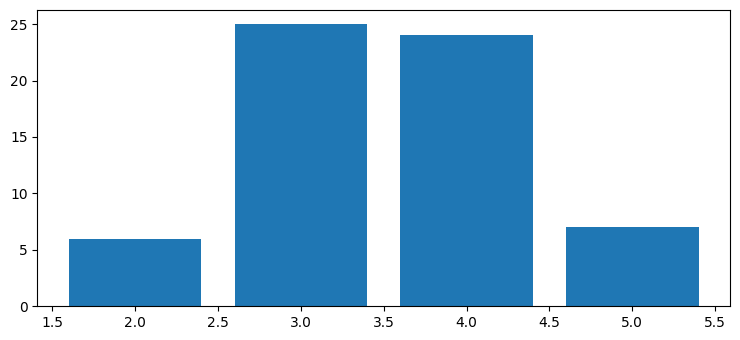

In [19]:
bpath_lens = Counter(bp_path_lengths)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.bar(bpath_lens.keys(), bpath_lens.values())

plt.show()

Now, it also looks like no paths ending in BP are longer than 5 edges.

How many unique BPs act as sink nodes here?

In [20]:
len(bps)

34

In [21]:
bp_paths

[{'directed': True,
  'multigraph': True,
  'graph': {'drug': 'imatinib',
   'disease': 'Systemic mast cell disease',
   'drugbank': 'DB00619',
   'drug_mesh': 'MESH:D000068877',
   'disease_mesh': 'MESH:D034721'},
  'nodes': [{'id': 'MESH:D000068877', 'name': 'imatinib', 'label': 'Drug'},
   {'id': 'UniProt:P10721', 'name': 'c-Kit', 'label': 'Protein'},
   {'id': 'GO:0008283',
    'name': 'Cellular proliferation',
    'label': 'Biological Process'},
   {'id': 'MESH:D034721',
    'name': 'Systemic mast cell disease',
    'label': 'Disease'}],
  'links': [{'source': 'MESH:D000068877',
    'target': 'UniProt:P10721',
    'key': 'INHIBITS'},
   {'source': 'UniProt:P10721', 'target': 'GO:0008283', 'key': 'UP_REGULATES'},
   {'source': 'GO:0008283', 'target': 'MESH:D034721', 'key': 'CAUSES'}]},
 {'directed': True,
  'multigraph': True,
  'graph': {'drug': 'imatinib',
   'disease': 'Systemic mast cell disease',
   'drugbank': 'DB00619',
   'drug_mesh': 'MESH:D000068877',
   'disease_mesh': '

**It is worth noting that there are lots of non-drug compounds in here, such as carbovir triphosphate and prostaglandins, which act as middle players in the paths.**

## DrugMechDB overlap with dataset

To use DrugMechDB as a validation set, let's see how much it overlaps with our data. 

First, we can see which BPs are also within our GO BP set from the ChEMBL dataset.

In [29]:
KG_DIR = '../data/kg'

In [33]:
feasible_bps = pd.read_csv(osp.join(KG_DIR, "feasible_go_bps.tsv"), sep="\t", index_col=0)

In [34]:
feasible_bps.head()

,go_id,go_term,num_drugs,num_prots
0,GO:0008150,biological_process,181,93
1,GO:0010951,negative regulation of endopeptidase activity,33,33
2,GO:0006805,xenobiotic metabolic process,153,92
3,GO:0006629,lipid metabolic process,169,104
4,GO:0030154,cell differentiation,143,285


In [35]:
feas_gobps = set(feasible_bps['go_id'])

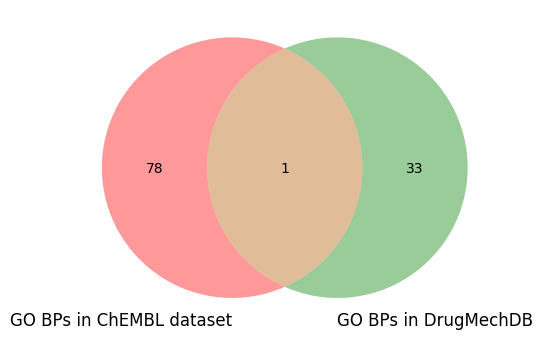

In [47]:
venn2_unweighted(
    [feas_gobps, bps],
    set_labels=['GO BPs in ChEMBL dataset', 'GO BPs in DrugMechDB']
)

Okay, yikes. Only one GO BP is in the set from ChEMBL. Let's see how the overlap with the KGs is.

In [39]:
openbiolink_df = pd.read_csv(osp.join(KG_DIR, 'openbiolink_filtered.tsv'), sep='\t')
custom_df = pd.read_csv(osp.join(KG_DIR, 'customkg_filtered.tsv'), sep='\t')

In the `enrichment` notebook, we made a filtered mapping dataframe with GO annotations:

In [40]:
MAPPING_DIR = '../data/mappings'

In [41]:
filtered_df = pd.read_csv('../data/mappings/in_kg_go_terms.tsv', sep='\t')

In [42]:
filtered_df.head()

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
0,9606,ncbigene:2,GO:0001553,IEA,involved_in,luteinization,-,Process
1,9606,ncbigene:2,GO:0001869,IDA,involved_in,"negative regulation of complement activation, ...",12538697,Process
2,9606,ncbigene:2,GO:0002020,IBA,enables,protease binding,21873635,Function
3,9606,ncbigene:2,GO:0002020,IPI,enables,protease binding,7679575|18485748,Function
4,9606,ncbigene:2,GO:0002438,IEA,involved_in,acute inflammatory response to antigenic stimulus,-,Process


In [43]:
bps_in_kg = set(filtered_df['GO_ID'])

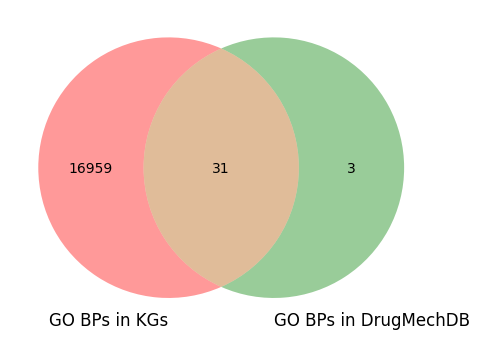

In [46]:
venn2_unweighted(
    [bps_in_kg, bps],
    set_labels=['GO BPs in KGs', 'GO BPs in DrugMechDB']
)

Cool, at least most of them exist in the KG! That is important because we know they are at least connected to a protein and can be mapped.

What about the drugs between DrugMechDB and the KG? First, we will have to map the drugs from DrugBank to PubChem.

In [48]:
# Get all the KG drugs:
obl_drugs = {d for d in openbiolink_df['source'] if 'pubchem.compound' in d}
custom_drugs = {d for d in custom_df['source'] if 'pubchem.compound' in d}

In [49]:
custom_drugs.update(obl_drugs)

I got a mapping file from [DrugBank](https://go.drugbank.com), which requires a private login/ license.

In [86]:
drugbank_mapping = pd.read_csv(osp.join(MAPPING_DIR, "drugbank_all_drug_links.csv.zip"))

In [87]:
drugbank_mapping.head()

,DrugBank ID,Name,CAS Number,Drug Type,KEGG Compound ID,KEGG Drug ID,PubChem Compound ID,PubChem Substance ID,ChEBI ID,PharmGKB ID,...,GenBank ID,DPD ID,RxList Link,Pdrhealth Link,Wikipedia ID,Drugs.com Link,NDC ID,ChemSpider ID,BindingDB ID,TTD ID
0,DB00001,Lepirudin,138068-37-8,BiotechDrug,NaN,D06880,NaN,46507011.0,NaN,PA450195,...,NaN,11916,http://www.rxlist.com/cgi/generic/lepirudin.htm,NaN,Lepirudin,http://www.drugs.com/cdi/lepirudin.html,NaN,NaN,NaN,DAP000541
1,DB00002,Cetuximab,205923-56-4,BiotechDrug,NaN,D03455,NaN,46507042.0,NaN,PA10040,...,J00228,13175,http://www.rxlist.com/cgi/generic3/erbitux.htm,NaN,Cetuximab,http://www.drugs.com/cdi/cetuximab.html,NaN,NaN,NaN,DNC000788
2,DB00003,Dornase alfa,143831-71-4,BiotechDrug,NaN,NaN,NaN,46507792.0,NaN,PA10318,...,M55983,650,http://www.rxlist.com/cgi/generic/pulmozyme.htm,NaN,Dornase_alfa,http://www.drugs.com/cdi/dornase-alfa.html,NaN,NaN,NaN,DAP000981
3,DB00004,Denileukin diftitox,173146-27-5,BiotechDrug,NaN,NaN,NaN,46506950.0,NaN,PA164750594,...,V01536,NaN,http://www.rxlist.com/cgi/generic2/denileukin.htm,NaN,Denileukin_diftitox,http://www.drugs.com/cdi/denileukin-diftitox.html,NaN,NaN,NaN,DAP001098
4,DB00005,Etanercept,185243-69-0,BiotechDrug,C07897,D00742,NaN,46506732.0,NaN,PA449515,...,M32315,12032,http://www.rxlist.com/cgi/generic/etanercept.htm,NaN,Etanercept,http://www.drugs.com/cdi/etanercept.html,NaN,NaN,NaN,DNC000605


Looks like we need the PubChem IDs without their prefixes:

In [88]:
cids = [cid.split(':')[1] for cid in custom_drugs]

The PubChem IDs are floats in the table. This is probably because there are NaNs.

In [89]:
drugbank_mapping.columns

Index(['DrugBank ID', 'Name', 'CAS Number', 'Drug Type', 'KEGG Compound ID',
       'KEGG Drug ID', 'PubChem Compound ID', 'PubChem Substance ID',
       'ChEBI ID', 'PharmGKB ID', 'HET ID', 'UniProt ID', 'UniProt Title',
       'GenBank ID', 'DPD ID', 'RxList Link', 'Pdrhealth Link', 'Wikipedia ID',
       'Drugs.com Link', 'NDC ID', 'ChemSpider ID', 'BindingDB ID', 'TTD ID'],
      dtype='object')

In [117]:
db2pc = {}
for dbid, pcid in zip(drugbank_mapping['DrugBank ID'], drugbank_mapping['PubChem Compound ID']):
    if not math.isnan(pcid):
        db2pc[dbid] = int(pcid)
    #else:
    #    db2pc[dbid] = pcid

In [118]:
# Get all drugs from DrugMechDB
dmdb_drugs = set(indications['db_id'])

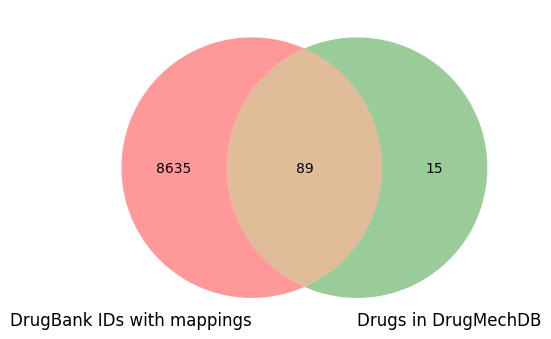

In [119]:
venn2_unweighted(
    [set(db2pc.keys()), dmdb_drugs],
    set_labels=['DrugBank IDs with mappings', 'Drugs in DrugMechDB']
)

15 of the drugs in DrugMechDB do not have mappings.

In [120]:
dmdb_drug_pc_ids = {str(db2pc[d]) for d in set(db2pc.keys()).intersection(dmdb_drugs)}

In [121]:
len(dmdb_drug_pc_ids)

89

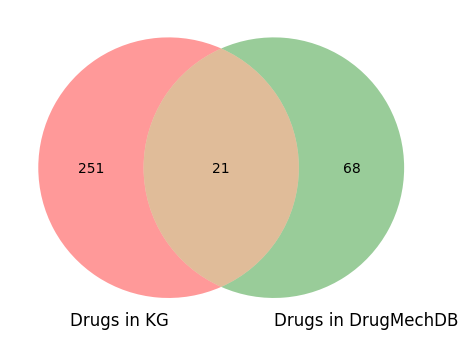

In [122]:
venn2_unweighted(
    [set(cids), dmdb_drug_pc_ids],
    set_labels=['Drugs in KG', 'Drugs in DrugMechDB']
)

Only 21 of those 89 are in the KG.

## Metapaths

Finally, let's explore the metapaths a bit.

There are two sheets for metapaths. One is the original metapaths:

In [22]:
metapaths = pd.read_excel(dm_db, 'metapaths')

In [23]:
metapaths.head()

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,Drug,INHIBITS,Protein,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Drug,INHIBITS,Pathway,ASSOCIATED_WITH,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Drug,INHIBITS,Protein,PRODUCES,Compound Class,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


... and another is Biolink metapaths: 

`"Version 1.1.0 includes a new tab 'metapaths_biolink' where the majority of node and edge types have been mapped to entities and relationship slots in the biolink model."`

In [24]:
metapaths_biolink = pd.read_excel(dm_db, 'metapaths_biolink')

In [25]:
metapaths_biolink.head()

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,Drug,decreases activity of,Protein,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drug,decreases activity of,Protein,positively regulates,BiologicalProcess,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Drug,decreases activity of,Protein,positively regulates,BiologicalProcess,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Drug,negatively regulates,Pathway,affects risk for,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Drug,decreases activity of,Protein,increases abundance of,NaN,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I think we'll use the biolink-adjusted ones. How long are these metapaths, typically?

In [26]:
Counter([(row.count() - 1) / 2 for i, row in metapaths_biolink.iterrows()])

Counter({4.0: 55,
         3.0: 33,
         2.0: 13,
         5.0: 7,
         2.5: 5,
         3.5: 4,
         1.0: 3,
         4.5: 1,
         6.5: 1,
         6.0: 1})

This is pretty weird, since some of the metapaths have NaN in them. Otherwise, we wouldn't be getting anything other than integers for the path lengths.

What does NaN mean? Can it be any entity?

Maybe this is a problem with converting everything to Biolink- let's try the original DF:

In [27]:
len(metapaths)

123

In [28]:
Counter([(row.count() - 1) / 2 for i, row in metapaths.iterrows()])

Counter({4.0: 59, 3.0: 38, 2.0: 13, 5.0: 8, 1.0: 3, 7.0: 1, 6.0: 1})

For now, we aren't really using these metapaths, so I will conclude that exploration there.